In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

**Motivation & objective**

Imbalanced datasets are ubiquitous in real-world machine learning tasks, where one class significantly outnumbers the other(s). While this scenario is common, it poses significant challenges for traditional machine learning algorithms, which tend to be biased towards the majority class and perform poorly on minority classes. In this lab, we will explore three techniques to address the imbalance issue: subsampling, oversampling, and Synthetic Minority Over-sampling Technique (SMOTE). By implementing these techniques, we aim to improve the model's performance on imbalanced datasets and make our predictions more reliable.

---

**Importing the Dataset**:

Let's start by importing the Credit Card Fraud Detection dataset, a real-world example of an imbalanced dataset where fraudulent transactions are the minority class.

*Download the dataset here!!*

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [5]:
df = pd.read_csv("../data/creditcard.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# check the first rows of this dataset

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# this is extremely imbalanced

df['Class'].value_counts()

# but also expected, since frauds are a mere fraction of all transactions

Class
0    284315
1       492
Name: count, dtype: int64

**Train/Test Split and Baseline Model**

Before applying any techniques to handle the imbalance, let's establish a baseline model. 

We'll perform a simple train/test split and train a RandomForest classifier on the training set, evaluating its performance on the test set.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [10]:
# Splitting the data into train and test sets

X,y = df.drop(columns=['Class']), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

As we can see below, both splits are also heavily imbalanced

In [11]:
y_train.value_counts()

Class
0    227451
1       394
Name: count, dtype: int64

In [12]:
y_test.value_counts()

Class
0    56864
1       98
Name: count, dtype: int64

Training a RandomForest classifier

In [13]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Evaluating it on the test set

In [14]:
y_pred = rf_classifier.predict(X_test)

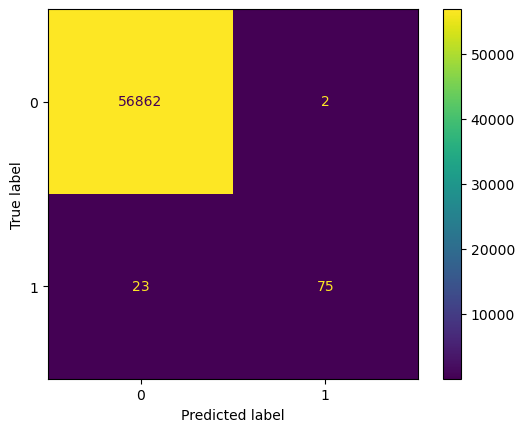

In [15]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show() 

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Baseline Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Baseline Model Performance:
Accuracy: 0.9995611109160493
Precision: 0.974025974025974
Recall: 0.7653061224489796


---

**Subsampling**

Subsampling involves reducing the number of samples in the majority class to balance the dataset. 

*However, it's essential to perform subsampling only on the training set to avoid information loss in the test set.* 

This point actually stands for any other sampling method aswell. We want our test set to represent reality, and we therefore, as usual, can't alter it.

In [17]:
# install the imblearn-package

!pip install imblearn

In [18]:
from imblearn.under_sampling import RandomUnderSampler

# Subsampling the majority class in the training set

undersampler = RandomUnderSampler(random_state=42)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [19]:
# note that this is now balanced!

y_train_resampled.value_counts()

Class
0    394
1    394
Name: count, dtype: int64

Training a RandomForest classifier

In [20]:
# Training a new RandomForest classifier on the resampled data

rf_classifier_resampled = RandomForestClassifier(random_state=42)
rf_classifier_resampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

Evaluate it on the test set

In [21]:
y_pred_resampled = rf_classifier_resampled.predict(X_test)

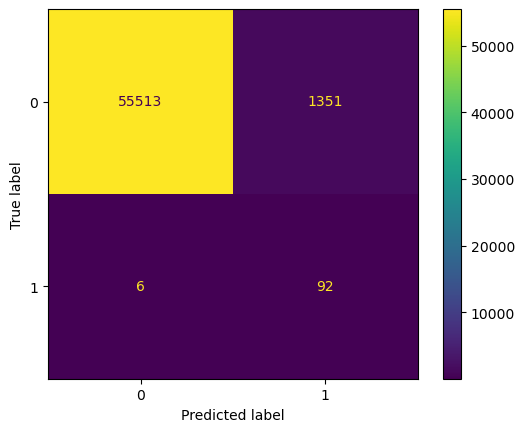

In [22]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_resampled)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show() 

In [23]:
accuracy_resampled = accuracy_score(y_test, y_pred_resampled)
precision_resampled = precision_score(y_test, y_pred_resampled)
recall_resampled = recall_score(y_test, y_pred_resampled)

print("Subsampling Model Performance:")
print("Accuracy:", accuracy_resampled)
print("Precision:", precision_resampled)
print("Recall:", recall_resampled)

Subsampling Model Performance:
Accuracy: 0.9761771005231558
Precision: 0.06375606375606375
Recall: 0.9387755102040817


---

**Oversampling**

Oversampling involves increasing the number of samples in the minority class to balance the dataset.

In [24]:
from imblearn.over_sampling import RandomOverSampler

# Oversampling the minority class in the training set

oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

In [25]:
# notice that this is now balanced!

In [26]:
y_train_oversampled.value_counts()

Class
0    227451
1    227451
Name: count, dtype: int64

Train a RandomForest Classifier

In [27]:
rf_classifier_oversampled = RandomForestClassifier(random_state=42)
rf_classifier_oversampled.fit(X_train_oversampled, y_train_oversampled)

Evaluate it on the test set

In [ ]:
y_pred_oversampled = rf_classifier_oversampled.predict(X_test)

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_oversampled)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show() 

In [ ]:
accuracy_oversampled = accuracy_score(y_test, y_pred_oversampled)
precision_oversampled = precision_score(y_test, y_pred_oversampled)
recall_oversampled = recall_score(y_test, y_pred_oversampled)

print("\nOversampling Model Performance:")
print("Accuracy:", accuracy_oversampled)
print("Precision:", precision_oversampled)
print("Recall:", recall_oversampled)

---

**SMOTE (Synthetic Minority Over-sampling Technique)**

SMOTE generates synthetic samples for the minority class to balance the dataset.

In [ ]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# note that this is now balanced

y_train_smote.value_counts()

Train a RandomForest classifier

In [ ]:
rf_classifier_smote = RandomForestClassifier(random_state=42)
rf_classifier_smote.fit(X_train_smote, y_train_smote)

Evaluate it on the test set

In [ ]:
y_pred_smote = rf_classifier_smote.predict(X_test)

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_smote)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

cm_display.plot()
plt.show() 

In [ ]:
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)

print("\nSMOTE Model Performance:")
print("Accuracy:", accuracy_smote)
print("Precision:", precision_smote)
print("Recall:", recall_smote)

---

## Challenges 

**Task 1**

Understand everything we've done above.

**Task 2**

Recall that we in the binary classification case, predict the class which has the biggest probability. 

Since there are only 2 classes, we predict the one which has 0.5 (by default).

However, oftentimes it's worth altering this prediction threshold/cutoff to something else. This way, we can also affect our accuracy/precision/recall.

Run the code below to see how to do this.

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)   

In [ ]:
# get all prediction probabilities

prediction_probabilities = rf.predict_proba(X_test)

# extract only the probabilities for the positive class

prediction_for_positive_class = prediction_probabilities[:, 1]

In [ ]:
# Define the range of threshold values

threshold_values = np.linspace(0.2,0.8,25)

threshold_values

The above threshold values are what we will loop over below. Specifically, each threshold represents the required probability for class 1 for us to predict it.

In [ ]:
# Loop through each threshold value
for threshold in threshold_values:

    # Convert predicted probabilities to binary predictions based on the current threshold
    y_pred = (prediction_for_positive_class >= threshold).astype(int)
    
    accuracy = round(accuracy_score(y_test, y_pred),4)
    precision = round(precision_score(y_test, y_pred),4)
    recall = round(recall_score(y_test, y_pred),4)
    
    # Print the metrics for the current threshold
    print(f'Threshold : {round(threshold,2)}')
    print(f'Accuracy  : {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}', end='\n\n')

**Task 3**

Do the above analysis again, but instead use the classifiers you've trained on the differently pre-processed training sets above.